In [1]:
import re, pickle, collections, numpy as np, keras, math, operator, pdb

#from gensim.models import word2vec, KeyedVectors
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from glob import glob
from torch.utils.data import DataLoader
from PIL import Image
FLOAT_DTYPE = torch.cuda.FloatTensor
LONG_DTYPE = torch.cuda.LongTensor

%matplotlib inline


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5103, 6021))


In [20]:
dpath = 'flikr8/'
imgpath =  'flikr8/Flicker8k_Dataset/' 
tr_img_path = imgpath +'train/'
dev_img_path = imgpath +'dev/'
embed_path = 'glove.6B.300d.txt'
BATCH_SIZE=32
MAX_LEN=30
NUM_DEC_LAYERS=2

In [33]:
dev_caps = pickle.load(open(dpath+'dev_first_caps.pkl', 'rb'))
tr_caps = pickle.load(open(dpath+'train_first_caps.pkl', 'rb'))

dev_caps[0], tr_caps[0]

In [35]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

In [36]:
tokens = {name: simple_toks(words) for name, words in tr_caps}
dev_tokens = {name: simple_toks(words) for name, words in dev_caps}

keys = list(tokens.keys()); tokens[keys[0]]

['a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.']

In [37]:
PAD = 0; SOS = 1; EOS = 2; UNK=3
def toks2ids(sents):
    #create new counter from all tokens in all lines
    sents_vals = list(sents.values())
    voc_cnt = collections.Counter(t for sent in sents_vals for t in sent) 
    
    #sort vocab in reverse order
    vocab = sorted(voc_cnt, key=voc_cnt.get, reverse=True)
    
    vocab.insert(PAD, "<PAD>")
    vocab.insert(SOS, "<SOS>")
    vocab.insert(EOS, "<EOS>")
    vocab.insert(UNK, "<UNK>")
    # {word: index of word}
    w2id = {w:i for i,w in enumerate(vocab)}
    #make each sentence into a list of ids
    ids = [[w2id[t] for t in sent] for sent in sents_vals]
    name_ids_dict = {name: id_vals for name, id_vals in zip(sents.keys(), ids)}
    return ids, vocab, w2id, voc_cnt, name_ids_dict

In [38]:
ids, vocab, w2id, counts, name_ids_dict = toks2ids(tokens)
id2w = {v: k for k, v in w2id.items()}


In [39]:
def turnId2W(ids):
    return ' '.join([id2w.get(id, '<UNK>') for id in ids])
names_from_dict = list(name_ids_dict.keys())
print(turnId2W(name_ids_dict[names_from_dict[0]]))

a child in a pink dress is climbing up a set of stairs in an entry way .


## Word vectors

In [40]:
def load_glove_me(loc):
    w2v = {}
    for line in open(loc):
        l = line.split()
        w2v[l[0]] = np.array(l[1:], dtype=np.float32)
    return w2v

In [41]:
w2v = load_glove_me(embed_path)
n_en_vec = len(w2v.keys()) #number of words encoded
dim_en_vec = len(w2v['the']) #dimension of embeddings -- we just use 'the' as a way to get it.

In [42]:
def create_emb_mat(w2v, targ_vocab, dim_vec):
    vocab_size = len(targ_vocab)
    emb = np.zeros((vocab_size, dim_vec)) #initialize empty container
    found=0
    for i, word in enumerate(targ_vocab): 
        try: emb[i] = w2v[word]; found+=1 #if we find it, use the word's vecotrs
        except KeyError: emb[i] = np.random.normal(scale=0.6, size=(dim_vec,)) #else randomeness

    return emb, found

In [43]:
embs, found = create_emb_mat(w2v, vocab, dim_en_vec); embs.shape, found

((3822, 300), 3690)

## Prep data

In [67]:
def padAndEOS(ids, maxlen=MAX_LEN):
    ids = list(map(lambda x:  x + [EOS], ids))
    return pad_sequences(ids, maxlen+2, 'int64', "post", "post")
    padded = padAndEOS(ids)
padded = padAndEOS(ids)
turnId2W(padded[0])

'a child in a pink dress is climbing up a set of stairs in an entry way . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

## Data Loading

In [ ]:
mu = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
scaleCrop = transforms.Compose([transforms.Scale(299), transforms.CenterCrop((299, 299))])

norm = transforms.Normalize(mean=mu,std=std)
mu_rev = torch.FloatTensor(mu).unsqueeze(1).unsqueeze(1)
std_rev = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
preproc = transforms.Compose([scaleCrop, transforms.ToTensor(), norm])
#denorm = transforms.Lambda(lambda x: (x * torch.FloatTensor(std_rev)).expand_as(x) + torch.FloatTensor(mu_rev).expand_as(x))
#revTrans = transforms.Compose([denorm, transforms.ToPILImage()])

def denormF(x):
    std = torch.FloatTensor(std_rev).expand_as(x)
    mu = torch.FloatTensor(mu_rev).expand_as(x)
    return (x * std ) + mu


denorm = transforms.Lambda(denormF)
revTrans = transforms.Compose([denorm, transforms.ToPILImage()])

def long_t(arr): return Variable(torch.LongTensor(arr)).cuda()


def ImgCapLoader(dl, caps_dict, batch_size=BATCH_SIZE, shuffle=True, testing=False):
    if shuffle:
        dl.dataset.imgs = [(path, int(clazz)) for path, clazz in np.random.permutation(dl.dataset.imgs)]
    img_names = dl.dataset.imgs
    num_batches = len(img_names) // batch_size
    dl_iter = dl.__iter__()
    for i in range(0, len(img_names), batch_size):
        basenames = [path.basename(name) for name, clz in img_names[i:i+batch_size]]
        if not testing:
            ids = np.vstack(padAndEOS([caps_dict[name] for name in basenames]))
        else:
            ids = np.vstack(padAndEOS([[0.] for name in basenames]))
        imgs, _ = dl_iter.__next__()
        yield imgs, ids
        

def create_emb_layer(emb_mat, non_trainable=False):
    output_size, emb_size = emb_mat.size() # get size
    emb = nn.Embedding(output_size, emb_size) #lookup table for embeddings
    emb.load_state_dict({'weight': emb_mat}) #load pretrained embeddings into embedding lookup
    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

In [47]:
def create_emb_layer(emb_mat, non_trainable=False):
    output_size, emb_size = emb_mat.size() # get size
    emb = nn.Embedding(output_size, emb_size) #lookup table for embeddings
    emb.load_state_dict({'weight': emb_mat}) #load pretrained embeddings into embedding lookup
    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

class Encoder(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE, emb_size=300, pool_size=8, fc_in_size=2048, testing=False):
        super(Encoder, self).__init__()
        self.batch_size=batch_size
        self.emb_size= emb_size
        self.poolInput = nn.AvgPool2d(pool_size)
        self.toEmbed = nn.Linear(fc_in_size, emb_size, bias=False)
        self.cnn = inception_v3(pretrained=True)
        for param in self.cnn.parameters(): 
            param.requires_grad = False
        if testing:
            self.cnn.eval()

        targ_layer = self.cnn._modules.get('Mixed_7c')
        self.out = torch.zeros([self.batch_size, fc_in_size, pool_size, pool_size]).type(FLOAT_DTYPE)
        def fun(m, i, o): self.out.copy_(o.data)
        self.h = targ_layer.register_forward_hook(fun)
        
    def forward(self, x):
        _ = self.cnn(x)
        x = self.poolInput(Variable(self.out))
        x = x.view(self.batch_size, -1)
        
        return self.toEmbed(x)
        

class Decoder(nn.Module):
    def __init__(self, embeds, num_layers=2, batch_size=BATCH_SIZE):
        super(Decoder, self).__init__()
        self.batch_size = BATCH_SIZE
        self.num_layers = num_layers
        self.embed, self.emb_size, self.output_size = create_emb_layer(embeds, non_trainable=True)
        self.gru = nn.GRU(input_size=self.emb_size, hidden_size=self.emb_size, num_layers=num_layers)
        self.out = nn.Linear(self.emb_size, self.output_size)
        
    
    def forward(self, input, hidden):
        x = self.embed(input)
        x, hidden = self.gru(x.unsqueeze(0), hidden)
        return F.log_softmax(self.out(x.squeeze(0))), hidden

### Validate

total number of images / batch_size = number of losses

In [48]:
dev_name_cap_dict = {name:cap  for (name,cap) in dev_caps}
tr_name_cap_dict = {name:cap  for (name,cap) in tr_caps}

In [51]:
def createValNameIdsDict(sents, vocab):
    #create new counter from all tokens in all lines
    sents_vals = list(sents.values())    
    # {word: index of word}
    w2id = {w:i for i,w in enumerate(vocab)}
    #make each sentence into a list of ids
    ids = [[w2id.get(t, UNK) for t in sent] for sent in sents_vals]
    name_ids_dict = {name: id_vals for name, id_vals in zip(sents.keys(), ids)}
    return ids, name_ids_dict

dev_ids, dev_name_ids_dict = createValNameIdsDict(dev_tokens, vocab)


In [58]:
turnId2W(dev_ids[2])

'a woman crouches near three dogs in a field .'

In [60]:
enc = Encoder(batch_size=BATCH_SIZE, testing=True)
embs_t = torch.FloatTensor(embs)
dec = Decoder(embs_t, batch_size=BATCH_SIZE, num_layers=NUM_DEC_LAYERS)
#enc.load_state_dict(torch.load('models/enc_gru_adam_2.pt'))
#dec.load_state_dict(torch.load('models/dec_gru_adam_2.pt'))
if FLOAT_DTYPE == torch.cuda.FloatTensor:
    enc.cuda()
    dec.cuda()

dev_ds = ImageFolder(dev_img_path, transform=preproc)
dev_dl = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False)


In [61]:
dev_loader = ImgCapLoader(dev_dl, dev_name_ids_dict, batch_size=BATCH_SIZE, testing=False)

In [84]:
def validate(dl, cap_dict, enc, dec, batch_size=BATCH_SIZE, crit=nn.NLLLoss()):
    loader = ImgCapLoader(dl, cap_dict, batch_size)
    num_steps = len(dl.dataset.imgs) // BATCH_SIZE
    pdb.set_trace()
    tot_loss = 0.0
    for i, (imgs, ids) in enumerate(loader):
        if i == (num_steps - 1):break
        print('Validating {} of {} steps'.format(i, num_steps))
        loss = 0.0
        targ_len = ids.shape[1]
        ids = Variable(torch.LongTensor(ids)).type(LONG_DTYPE)
        dec_input = long_t([SOS]*imgs.size()[0]).type(LONG_DTYPE)
        hidden = enc(Variable(imgs).type(FLOAT_DTYPE)).unsqueeze(0).repeat(dec.num_layers, 1, 1)
        for di in range(targ_len):
            dec_output, hidden = dec(dec_input, hidden) #get output hidden
            _, dec_input = dec_output.topk(1)            
            dec_input = dec_input.squeeze(1)
            loss += crit(dec_output, dec_input) #compute loss
        tot_loss += loss.data[0]
    return tot_loss / (num_steps - 1)


In [82]:
val_loss = validate(dev_dl, dev_name_ids_dict, enc, dec)

> <ipython-input-81-54daf76021ea>(5)validate()
-> tot_loss = 0.0
(Pdb) c
Validating 0 of 31 steps


/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Validating 1 of 31 steps
Validating 2 of 31 steps
Validating 3 of 31 steps
Validating 4 of 31 steps
Validating 5 of 31 steps
Validating 6 of 31 steps
Validating 7 of 31 steps
Validating 8 of 31 steps
Validating 9 of 31 steps
Validating 10 of 31 steps
Validating 11 of 31 steps
Validating 12 of 31 steps
Validating 13 of 31 steps
Validating 14 of 31 steps
Validating 15 of 31 steps
Validating 16 of 31 steps
Validating 17 of 31 steps
Validating 18 of 31 steps
Validating 19 of 31 steps
Validating 20 of 31 steps
Validating 21 of 31 steps
Validating 22 of 31 steps
Validating 23 of 31 steps
Validating 24 of 31 steps
Validating 25 of 31 steps
Validating 26 of 31 steps
Validating 27 of 31 steps
Validating 28 of 31 steps
Validating 29 of 31 steps



## Evaluate

In [20]:
dev_name_cap_dict = {name:cap  for (name,cap) in dev_caps}

tr_name_cap_dict = {name:cap  for (name,cap) in tr_caps}

In [21]:
def evaluate(enc, dec, img_dl, batch_size=BATCH_SIZE, targ_len=MAX_LEN+2):
    for imgs, _ in img_dl:  
        dec_input = long_t([SOS]*imgs.size()[0]).type(LONG_DTYPE) 
        hidden = enc(Variable(imgs).type(FLOAT_DTYPE)).unsqueeze(0).repeat(dec.num_layers, 1, 1)   
        outs = []        
        for di in range(targ_len):
            dec_output, hidden = dec(dec_input, hidden) 
            _, dec_input = dec_output.topk(1)            
            dec_input = dec_input.squeeze(1)
            outs.append(dec_input.data.cpu().numpy())
        break
    return np.vstack(outs).T, img_dl.dataset.imgs

In [47]:
enc = Encoder(batch_size=BATCH_SIZE, testing=True)
embs_t = torch.FloatTensor(embs)
dec = Decoder(embs_t, batch_size=BATCH_SIZE, num_layers=NUM_DEC_LAYERS)
enc.load_state_dict(torch.load('models/enc_gru_adam_2.pt'))
dec.load_state_dict(torch.load('models/dec_gru_adam_2.pt'))
if FLOAT_DTYPE == torch.cuda.FloatTensor:
    enc.cuda()
    dec.cuda()

dev_ds = ImageFolder(dev_img_path, transform=preproc)
dev_dl = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False)

tr_ds = ImageFolder(tr_img_path, transform=preproc)
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=False)
dev_preds, dev_img_names = evaluate(enc, dec, dev_dl, dev_name_cap_dict)
tr_preds, tr_img_names = evaluate(enc, dec, tr_dl, tr_name_cap_dict)

/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [48]:
def vizRes(preds, dev_name_cap_dict, img_names):
    ix = np.random.randint(0, len(preds) - 1)
    img_basename= path.basename(img_names[ix][0])
    print('True Caption: {}'.format(dev_name_cap_dict[img_basename]))
    print('Predicted Caption: {}'.format(turnId2W(preds[ix])))
    return Image.open(img_names[ix][0])


True Caption: A child and a woman are at waters edge in a big city .
Predicted Caption: a man is standing in front of a child in front of a lake . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


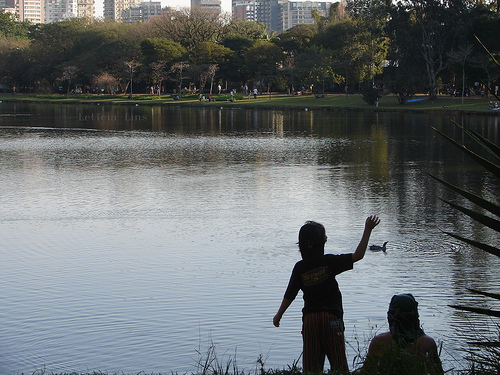

In [49]:
vizRes(dev_pred, dev_name_cap_dict, dev_img_names)

True Caption: A black dog and a spotted dog are fighting
Predicted Caption: a black dog and a spotted dog are fighting <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


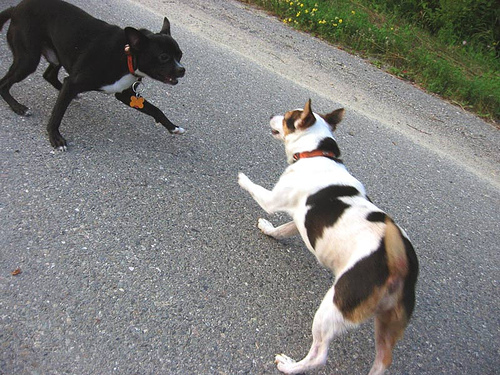

In [67]:
vizRes(tr_preds, tr_name_cap_dict, tr_img_names)

### Beam Search

In [68]:
def beam_search(enc, dec, img, targ_len=MAX_LEN+2, beam=2, SOS=SOS, EOS=EOS):
    totSol = []
    long_t = lambda x: Variable(torch.LongTensor(x)).type(LONG_DTYPE)
    hidden = enc(Variable(img).type(FLOAT_DTYPE)).unsqueeze(0).repeat(dec.num_layers, 1, 1)   

    start = {'pr':1.0, 'i': [long_t([SOS])], 'h': hidden}
    cands = [start]
    for ts in range(targ_len):
        temp_cands = []
        for c in cands:
            o, h = dec(c['i'][-1], c['h'])
            top_p, top_i = torch.topk(o, beam)
            for t in range(top_p.size()[1]):    
                tc = {'pr': top_p[:, t] + c['pr'], 'i': c['i'][:] + [top_i[:, t]], 'h': h}
                if tc['i'][-1].data[0] == EOS:
                    totSol.append(tc)
                else:
                    temp_cands.append(tc)
        temp_cands = sorted(temp_cands, key=lambda x: x['pr'].data[0], reverse=True)
        #print(checkBeam(temp_cands))
        cands = temp_cands[:beam]

    all_sol = cands + totSol
    all_sol =  sorted(all_sol, key=lambda x: x['pr'].data[0], reverse=True)
    top_caps, _ = checkBeam(all_sol)
    return all_sol, top_caps
        

def checkBeam(cands):
    ids = list(map(lambda c: torch.cat(c['i']).data.cpu().numpy(), cands))
    prs = list(map(lambda c: c['pr'].data[0], cands))
    caps = map(lambda i: turnId2W(i), ids)
    return list(caps), prs

In [69]:
dev_name_cap_dict = {name:cap  for (name,cap) in dev_caps}

In [70]:
enc = Encoder(batch_size=1, testing=True)
embs_t = torch.FloatTensor(embs)
dec = Decoder(embs_t, batch_size=1, num_layers=NUM_DEC_LAYERS)
enc.load_state_dict(torch.load('models/enc_gru_adam_2.pt'))
dec.load_state_dict(torch.load('models/dec_gru_adam_2.pt'))
if FLOAT_DTYPE == torch.cuda.FloatTensor:
    enc.cuda()
    dec.cuda()


In [75]:
def vizBeamSearchRes(dev_name_cap_dict, img_path, enc, dec):
    img_names = list(dev_name_cap_dict.keys())
    sel_img = np.random.permutation(img_names)[0]
    beam_img_path= img_path+'wrap/{}'.format(sel_img)
    beam_img = Image.open(beam_img_path);     
    beam_img_proc = preproc(beam_img).unsqueeze(0);
    all_solutions, top_caps = beam_search(enc, dec, beam_img_proc, beam=3)
    return beam_img, all_solutions, top_caps, dev_name_cap_dict[sel_img]

A guy is doing a skateboard trick in front of a crowd .
['<SOS> a person standing in the air among lots a crowd . <EOS>', '<SOS> a person standing in the air among lots a shot . <EOS>', '<SOS> a person standing in the air among lots among lots from <EOS>', '<SOS> a person standing in the air among lots among lots from . <EOS>', '<SOS> a person standing in the air among lots among lots from lots . <EOS>']


/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


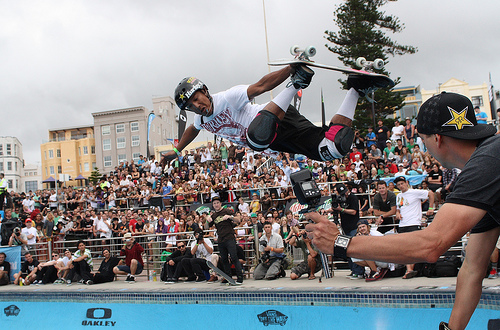

In [108]:
beam_img, all_sol, top_caps, true_cap = vizBeamSearchRes(dev_name_cap_dict, dev_img_path, enc, dec)
print(true_cap)
print(top_caps[:5])
beam_img